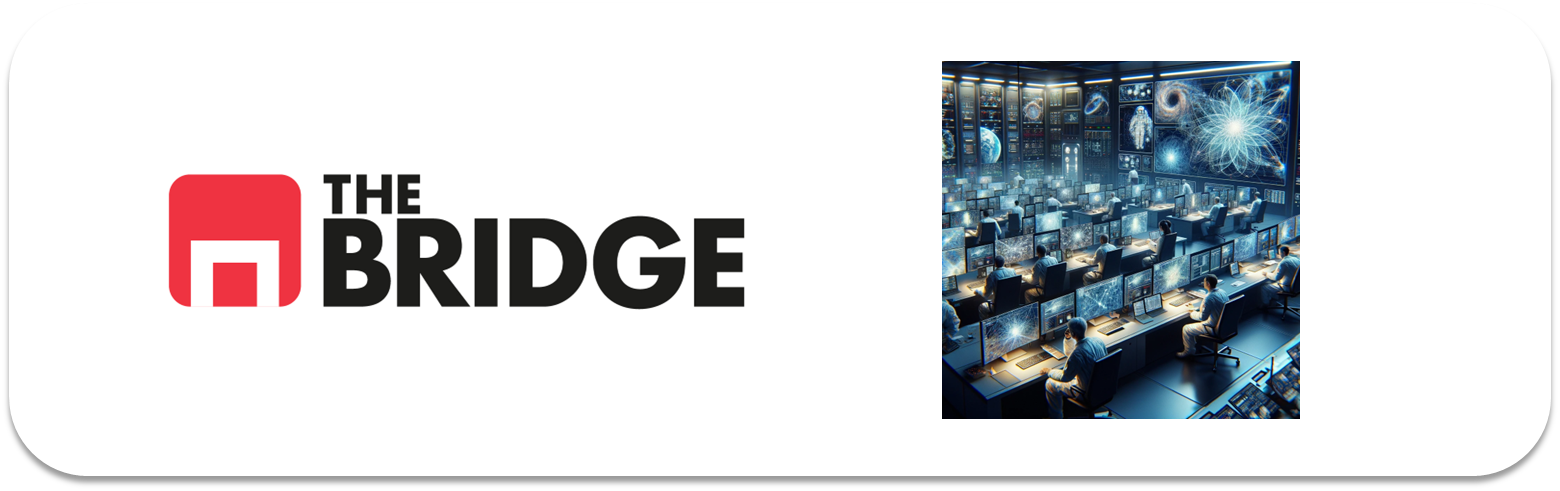

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Import whole class and then access using fully qualified names
from keras._tf_keras import keras

# Pylance not working
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

from utils import functions as fun

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



### Cargar los datos

Hare uso la función empleada en el workout pero ligeramente modificada para este caso de uso.

In [2]:
# Rutas a los archivos .zip
zip_files = [
    './data/github_train_0.zip',
    './data/github_train_1.zip',
    './data/github_train_2.zip',
    './data/github_train_3.zip',
    './data/github_test.zip'
]

# Extraer los ficheros contenidos
for zip_file in zip_files:
    fun.unzip_files(zip_file, './data/')

Extracted ./data/github_train_0.zip to ./data/
Extracted ./data/github_train_1.zip to ./data/
Extracted ./data/github_train_2.zip to ./data/
Extracted ./data/github_train_3.zip to ./data/
Extracted ./data/github_test.zip to ./data/


In [3]:
# Directorios que contienen las imagenes .jpg
train_directories = [
    'data/github_train_0',
    'data/github_train_1',
    'data/github_train_2',
    'data/github_train_3'
]

# Cargar las imágenes de train
X_train, y_train = None, None
for train_dir in train_directories:
    X, y = fun.load_images_from_directory(train_dir, reshape_dim=(32, 32))
    if X_train is None:
        X_train = X
        y_train = y
    else:
        X_train = np.concatenate((X_train, X), axis=0)
        y_train = np.concatenate((y_train, y), axis=0)

# Otro método: Cargar las imágenes de train
# X_train, y_train = [], []
# for train_dir in train_directories:
#     X, y = fun.load_images_from_directory(train_dir, reshape_dim=(32, 32))
#     X_train.extend(X)
#     y_train.extend(y)

# # Convertir listas a numpy arrays (por la forma en la que lo he encadenado)
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# Cargar imágenes de test
test_directory = 'data/github_test'
X_test, y_test = fun.load_images_from_directory(test_directory, reshape_dim=(32, 32))

print(f"Training data: {type(X_train)}, {X_train.shape}, {y_train.shape}")
print(f"Test data: {type(X_test)}, {X_test.shape}, {y_test.shape}")


Training data: <class 'numpy.ndarray'>, (4000, 32, 32, 3), (4000,)
Test data: <class 'numpy.ndarray'>, (1000, 32, 32, 3), (1000,)


Puedo comprobar que la cantidad de imágenes es la que indicaba el enunciado y las dimensiones de 32x32 pixeles con 3 canales (para los colores).

*Para ahorrar tiempo en el futuro y porque ocupa menos, lo que voy a hacer es almacenar en local los numpy.ndarray.*

In [4]:
# Guardar las variables en archivos separados
np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_test.npy', y_test)

In [2]:
# Cargar las variables guardadas
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')

print(f"Training data: {type(X_train)}, {X_train.shape}, {y_train.shape}")
print(f"Test data: {type(X_test)}, {X_test.shape}, {y_test.shape}")

Training data: <class 'numpy.ndarray'>, (4000, 32, 32, 3), (4000,)
Test data: <class 'numpy.ndarray'>, (1000, 32, 32, 3), (1000,)


### Mini-EDA: Inspeccionar los datos

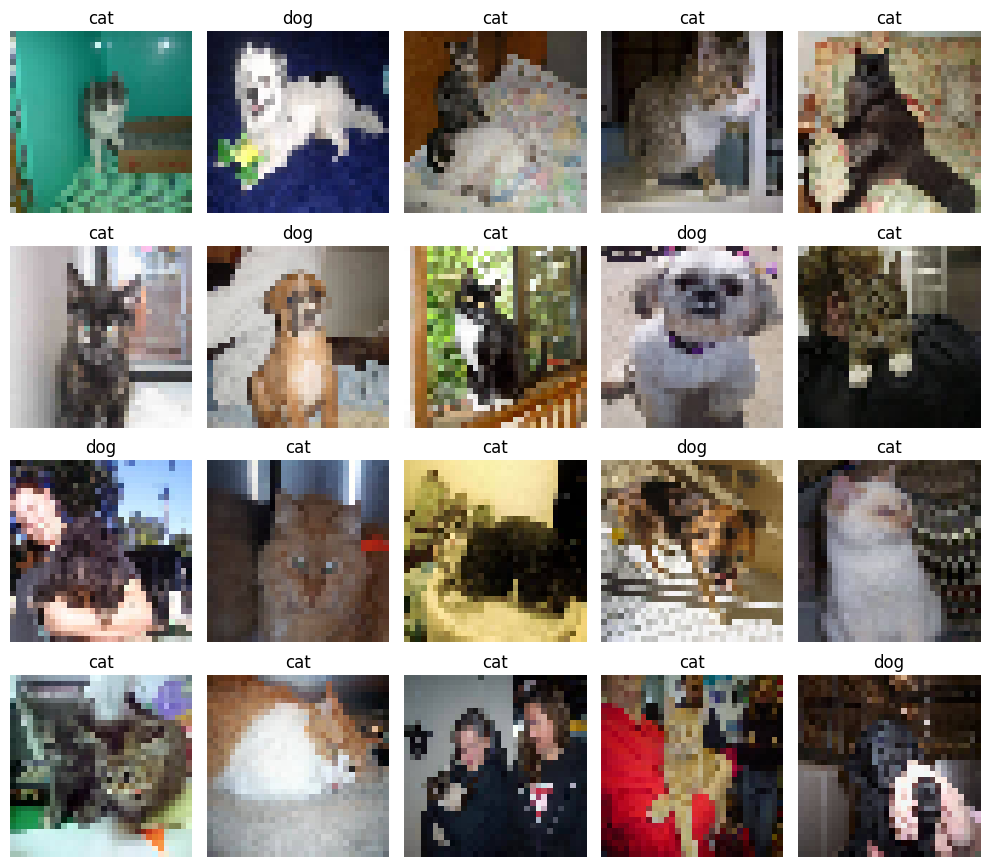

In [3]:
indices = np.random.randint(0, len(X_train), 20)
fun.show_images_batch(X_train[indices], 
                  titles=y_train[indices], 
                  n_cols = 5)

*A nuestra vista, la reduccion de la resolución afecta. Se podría cambiar el tamaño de resolución y probar, pero será a costa de tiempo de computación.*

In [4]:
pd.Series(y_train).value_counts(normalize=True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

*Voy a construir un clasificador binario y afortunadamente el set de train está perfectamente balanceado.*

### Transformar los datos

Lo primero que voy a hacer es comprobar si tengo datos faltantes, no numéricos o infinitos en alguno de los sets, porque en tal caso tendré que ver cómo proceder.

Claro que antes también hay que tranformar en númerica la variable *target*, ya que ahora contiene strings de "cat" y "dog".

In [5]:
y_train

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [6]:
# Codificado numérico del target --> {cat: 0, dog: 1}
le = LabelEncoder()

y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

In [7]:
y_train_num

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [8]:
fun.check_image_data([X_train, y_train_num, X_test, y_test_num])


Set 0: OK.
Set 1: OK.
Set 2: OK.
Set 3: OK.


No hay ningún dato faltante pero queda un paso muy importante para los modelos de DL: normalizar los datos. Para el caso de la imagenes es sencillo porque solo hay que dividir entre 255.


In [9]:
# Normalizar los datos
X_train = X_train / 255
X_test = X_test / 255

Recordemos que normalizar es bueno aunque estén en la misma escala por un lado porque las funciones de activación sulen trabajar mejor en rangos entre -1,0 y 1 (sobre todo las tanh, sigmoide, etc) y por otro porque valores altos de entrada sientan peor a la hora de hacer el gradiente descendente con backpropagation.

Además los datos están ordenados, por lo que debemos hacer un shuffle

In [10]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

### Modelo DL basado en redes convolucionales

De base voy a emplear un modelo similar al siguiente (y similar a la del workout):

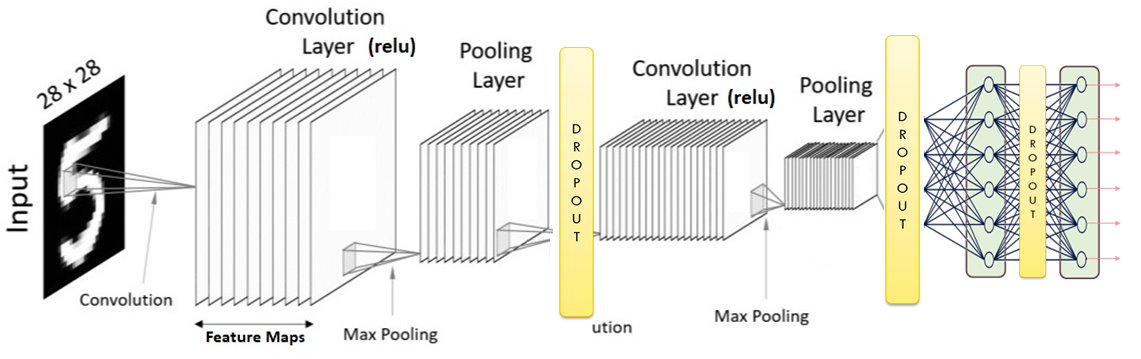

In [11]:
X_train.shape

(4000, 32, 32, 3)

*Para escoger el optimizador me fijo en el tamaño del dataset*

In [12]:
# 40000 fotos de train x 32 x 32 x 3
X_train.size 

12288000

*Dado el tamaño podemos usar un adam, cuyos hiperparámetros por defecto suelen funcionar bastante bien*

*Como es un problema de clasificación binaria, la función de activación de la capa de salida será una sigmoide.*

*Como el target es unidimensional usaré sparse_categorical_crossentropy, y como métrica dado el balanceo la accuracy.*


In [13]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, 
# seguido de una capa de pooling de 2x2, y un Dropout al 25 %.
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3.
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, 
# el número de filtros está escogido de aquella manera,

layers = [keras.layers.Conv2D(filters=30,
                              kernel_size=(3, 3),
                              padding='same', 
                              activation='relu',
                              input_shape = X_train[0].shape),
          keras.layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa de convolución, pooling y dropout
          keras.layers.Conv2D(filters=15,
                              kernel_size = (3, 3),
                              padding = 'same',
                              activation = 'relu'),
          keras.layers.MaxPooling2D(pool_size=(2, 2),
                                    strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos una capa de flatten para convertir la salida de la capa de dropout en un vector
          keras.layers.Flatten(),
          
          # Primera capa densa de clasificación, más dropout
          keras.layers.Dense(units=150, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa densa de clasificación, más dropout
          keras.layers.Dense(units=100, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos la capa de salida con 2 neuronas, y activación sigmoide por ser binaria
          keras.layers.Dense(units=2, 
                             activation='sigmoid')
          ]

# Crear el modelo
model = keras.models.Sequential(layers=layers)

# Compilar modelo
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
              )

# Información del modelo
model.summary()

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,357 (642.02 KB)

 Trainable params: 164,357 (642.02 KB)

 Non-trainable params: 0 (0.00 B)

Ahora entreno el modelo reservando un 20% de los datos para validar.

In [14]:
# Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience
cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10, 
                                                 restore_best_weights=True
                                                 )

# Entrenar el modelo
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping]
                    ) 

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5006 - loss: 0.7022 - val_accuracy: 0.5700 - val_loss: 0.6910
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5320 - loss: 0.6901 - val_accuracy: 0.5938 - val_loss: 0.6687
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5854 - loss: 0.6690 - val_accuracy: 0.6438 - val_loss: 0.6346
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6403 - loss: 0.6385 - val_accuracy: 0.6650 - val_loss: 0.6095
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6477 - loss: 0.6188 - val_accuracy: 0.6787 - val_loss: 0.6016
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6787 - loss: 0.5951 - val_accuracy: 0.6575 - val_loss: 0.6023
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6706 - loss: 0.6092 - val_accuracy: 0.6850 - val_loss: 0.5769
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7018 - loss: 0.5681 - val_accuracy: 0.

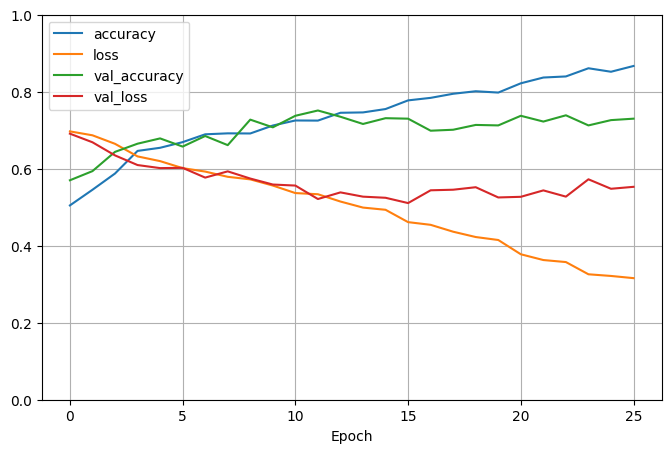

In [15]:
# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

El aumento de la precisión del modelo en el entrenamiento junto con la disminución de la pérdida es una buena señal durante las primeras épocas.

Sin embargo, el aumento de la pérdida en validación (val_loss) y la estabilización de la precisión en validación (val_accuracy) mientras la precisión de entrenamiento sigue mejorando sugiere que el modelo podría estar sobreajustándose a partir de la décima época, y por lo tanto, no generaliza bien en el conjunto de validación.

### Evaluar el modelo contra test


In [16]:
# Evaluar contra test
model.evaluate(X_test, y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7156 - loss: 0.5755


[0.5303957462310791, 0.7329999804496765]

*Un 73.3% de accuracy que se traduce en el siguiente report*

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Probabilidades de la predicción:
[[0.4127655  0.5312339 ]
 [0.46039283 0.5046246 ]
 [0.55911523 0.4279848 ]
 [0.5115802  0.47867453]
 [0.27718404 0.64793265]
 [0.64871335 0.34031218]
 [0.5418469  0.41755545]
 [0.41926444 0.5416927 ]
 [0.19379039 0.7059454 ]
 [0.5102998  0.44982675]]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicciones (numéricas):
[1 1 0 0 1 0 0 1 1 0]

Predicciones (categorias):
['dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat']

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       500
           1       0.72      0.77      0.74       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000


              precision    recall  f1-score   support

         cat       0.75      0.69      0.72       500
         dog       0.72      0.77      0.74       500

    ac

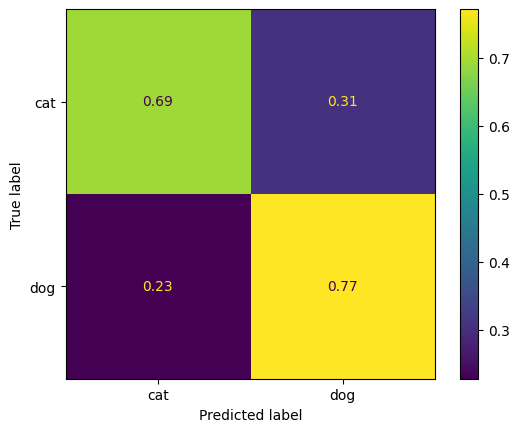

In [17]:
# Recordar que las predicciones dan en realidad una probabilidad de pertenecer a cada clase.
y_pred_proba = model.predict(X_test)
print('Probabilidades de la predicción:', y_pred_proba[0:10], sep='\n', end='\n\n')

# Predicciones numéricas
y_pred_num = np.array([np.argmax(predict_proba) for predict_proba in model.predict(X_test)])
print('Predicciones (numéricas):', y_pred_num[0:10], sep='\n', end='\n\n')

# Re-convertir a las clases "cat" y "dog"
y_pred = le.inverse_transform(y_pred_num)
print('Predicciones (categorias):', y_pred[0:10], sep='\n', end='\n\n')

# Reporte de clasificacición. La información es la misma, pero una es más sencilla de leer
print(classification_report(y_test_num, y_pred_num), end='\n\n')
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")

### Conclusiones del modelo

- Desequilibrio en la clasificación: El modelo tiene un sesgo leve hacia predecir correctamente gatos en comparación con perros, ya que la precisión y recall de los gatos son ligeramente más altos.

- Potencial mejora en la clasificación de perros: El 31% de los perros fueron mal clasificados como gatos, lo que sugiere que el modelo tiene dificultades para distinguir entre estas dos clases.

- Rendimiento general: El rendimiento del modelo es decente, pero hay margen para mejorar, especialmente en términos de recall para los perros. Podrías explorar más ajustando hiperparámetros.

### Selección de las peores clasificaciones

Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perros más alta.

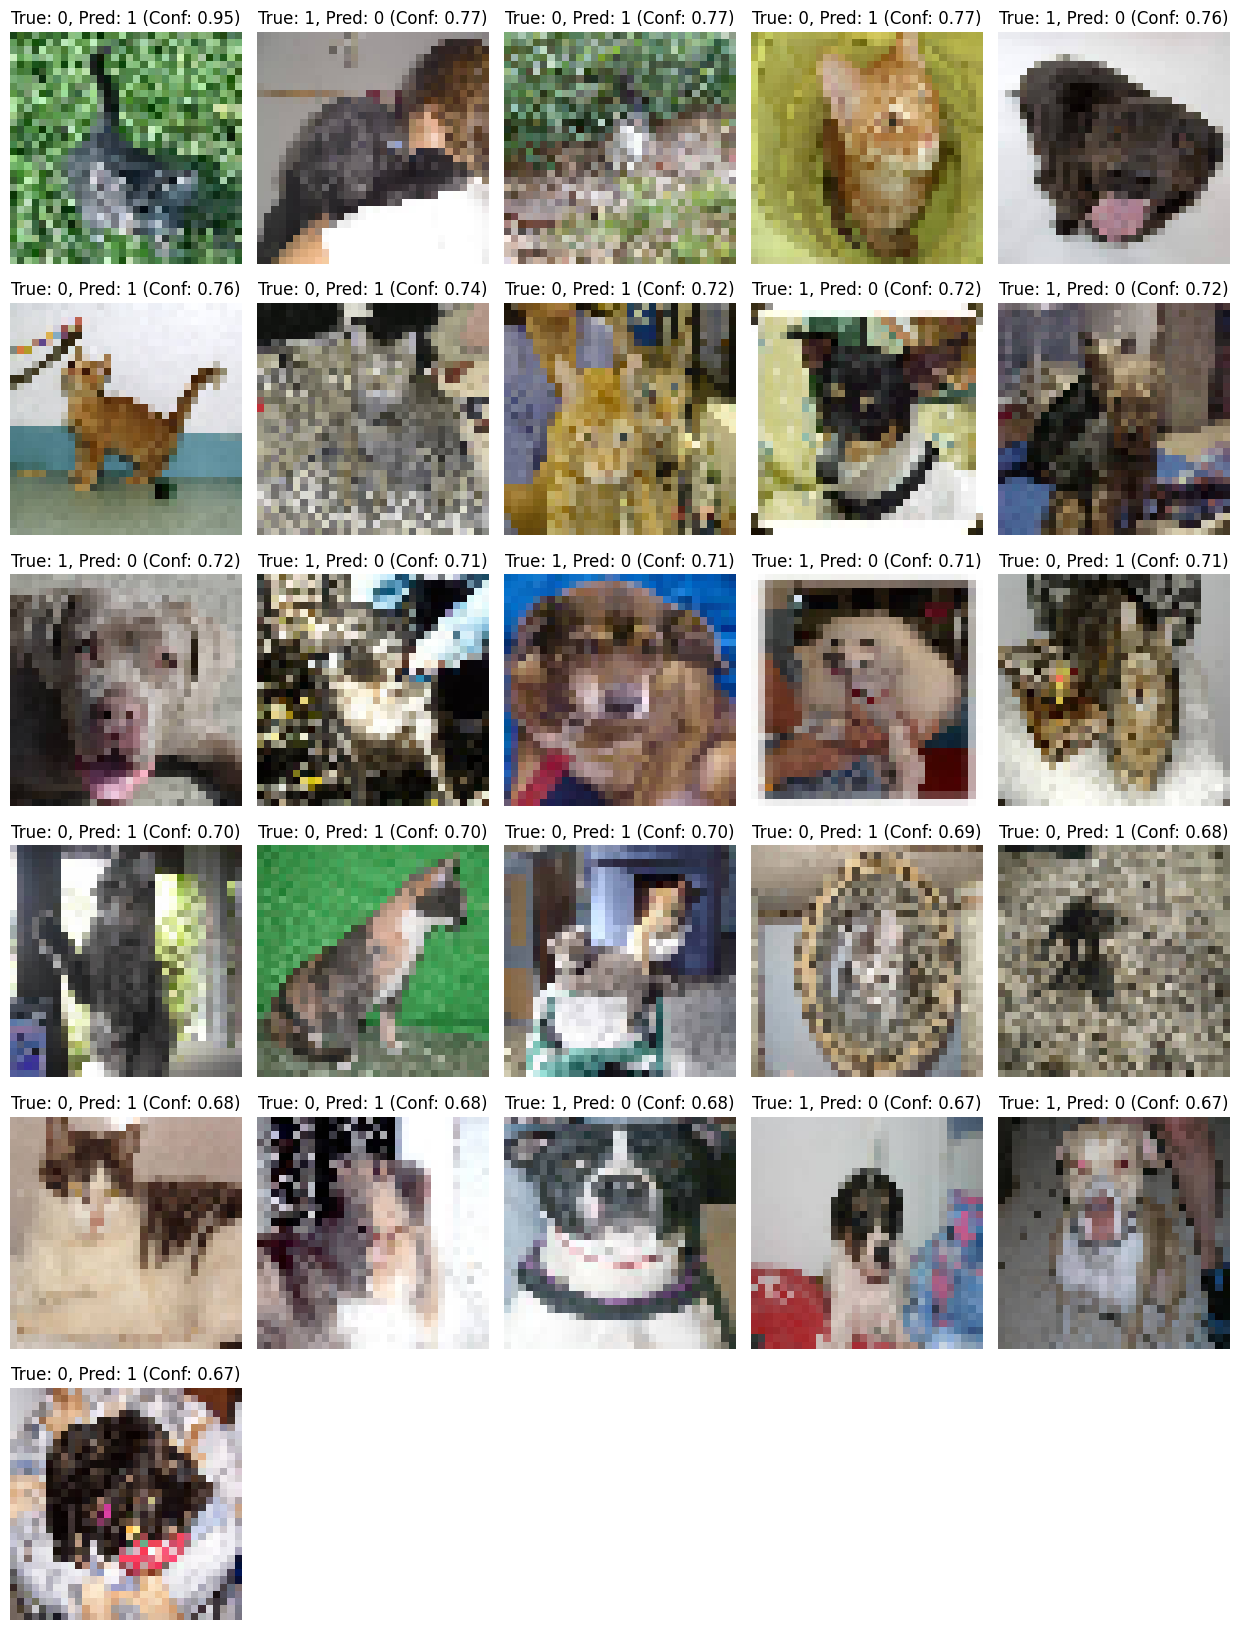

In [23]:
top_images, top_titles = fun.select_misclassified_images(X_test, 
                                                         y_test_num, 
                                                         y_pred_num, 
                                                         y_pred_proba, 
                                                         top_percentage=0.1
                                                         )

# Display the top misclassified images
fun.show_images_batch(top_images, titles=top_titles, n_cols=5, size_scale=2.5)


### Liberar memoria local

Si fuera necesario la siguientes líneas son para eliminar las carpetas de fotos y ficheros .npy que he creado.
Además GitHub tiene límite de almacenamiento.

In [24]:
# Eliminar carpetas que no sean .zip
directory = "./data"
fun.remove_non_zip_folders(directory)


Removing folder: ./data\github_test
Removing folder: ./data\github_train_0
Removing folder: ./data\github_train_1
Removing folder: ./data\github_train_2
Removing folder: ./data\github_train_3


In [25]:
# Eliminar ficheros .npy
directory = './data'
fun.remove_npy_files(directory)


Removing file: ./data\X_test.npy
Removing file: ./data\X_train.npy
Removing file: ./data\y_test.npy
Removing file: ./data\y_train.npy
